In this project, we will use time series data from COVID cases in India to see if we can forecast the number of cases effectively. We'll also see if there is seasonality to the COVID data, and whether a seasonal ARIMA model is therefore better at forecasting COVID cases. 

In [1]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
india = pd.read_csv("C:\\Users\\user\\Desktop\\Data\\COVID time series.csv")
india.head() # Check the data looks like what we expect

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30-Jan,1,1,0,0,0,0
1,31-Jan,0,1,0,0,0,0
2,01-Feb,0,1,0,0,0,0
3,02-Feb,1,2,0,0,0,0
4,03-Feb,1,3,0,0,0,0


The columns are self exaplanatory - we will look at daily cases to start with and not cumulative cases. Let's inspect that column, and the date column, to understand them a bit better

In [2]:
print(india["Date"].tail)
print(india["Date"].describe())

<bound method NDFrame.tail of 0     30-Jan
1     31-Jan
2     01-Feb
3     02-Feb
4     03-Feb
       ...  
88    27-Apr
89    28-Apr
90    29-Apr
91    30-Apr
92    01-May
Name: Date, Length: 93, dtype: object>
count         93
unique        93
top       18-Feb
freq           1
Name: Date, dtype: object


In [3]:
# We've got 93 dates from 30 Jan to 01 May, one for each day.
print(india["Daily Confirmed"].describe())

count      93.000000
mean      400.612903
std       610.710563
min         0.000000
25%         0.000000
50%        20.000000
75%       609.000000
max      2391.000000
Name: Daily Confirmed, dtype: float64


Daily cases ranges fro 0 to 2391. The mean is only 401 though, suggesting that we have lots of lower values and only a view
that are up near 2391. We can visualise this column to make it clearer:

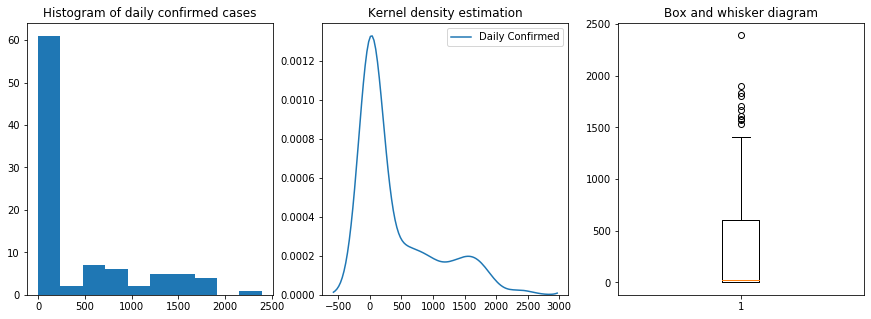

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.hist(india["Daily Confirmed"])
ax1.set_title("Histogram of daily confirmed cases")
sns.kdeplot(india["Daily Confirmed"], ax=ax2)
ax2.set_title("Kernel density estimation")
ax3.boxplot(india["Daily Confirmed"])
ax3.set_title("Box and whisker diagram")
plt.show()

In [5]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm # we'll need statsmodels for our forecasting model
dictionary = {"Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05"} # We'll need to replace the written months with numbers
for key in dictionary.keys():
    india["Date"] = india["Date"].str.replace(key, dictionary[key])
india["Date"][:30]

0     30-01
1     31-01
2     01-02
3     02-02
4     03-02
5     04-02
6     05-02
7     06-02
8     07-02
9     08-02
10    09-02
11    10-02
12    11-02
13    12-02
14    13-02
15    14-02
16    15-02
17    16-02
18    17-02
19    18-02
20    19-02
21    20-02
22    21-02
23    22-02
24    23-02
25    24-02
26    25-02
27    26-02
28    27-02
29    28-02
Name: Date, dtype: object

In [6]:
from datetime import datetime
india["Date"] = india["Date"] + "-2020"



In [7]:
india["Date"] = pd.to_datetime(india["Date"], format="%d-%m-%Y", errors="coerce")
india["Date"][:30]

0    2020-01-30
1    2020-01-31
2    2020-02-01
3    2020-02-02
4    2020-02-03
5    2020-02-04
6    2020-02-05
7    2020-02-06
8    2020-02-07
9    2020-02-08
10   2020-02-09
11   2020-02-10
12   2020-02-11
13   2020-02-12
14   2020-02-13
15   2020-02-14
16   2020-02-15
17   2020-02-16
18   2020-02-17
19   2020-02-18
20   2020-02-19
21   2020-02-20
22   2020-02-21
23   2020-02-22
24   2020-02-23
25   2020-02-24
26   2020-02-25
27   2020-02-26
28   2020-02-27
29   2020-02-28
Name: Date, dtype: datetime64[ns]

In [8]:
india.index = india["Date"] # We want the index to be datetime
india.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Date,,,,,,,
2020-01-30,2020-01-30,1,1,0,0,0,0
2020-01-31,2020-01-31,0,1,0,0,0,0
2020-02-01,2020-02-01,0,1,0,0,0,0
2020-02-02,2020-02-02,1,2,0,0,0,0
2020-02-03,2020-02-03,1,3,0,0,0,0


Text(0.5, 1.0, 'Confirmed daily cases in India')

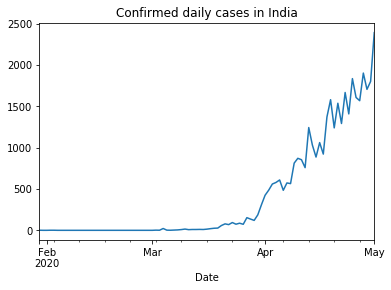

In [9]:
y = india["Daily Confirmed"] # We'll be using this a lot so let's give it a variable that's easier to type out each time!
y.plot() # Plot the number of daily confirmed cases
plt.title("Confirmed daily cases in India")

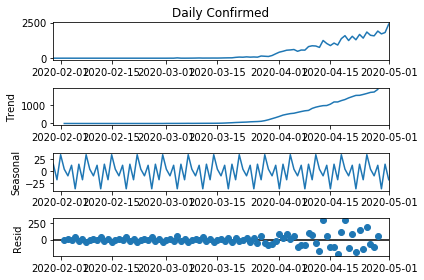

In [10]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive') # This is how we view the trend, seasonality and noise in the data
fig = decomposition.plot()
plt.show()

We can see some seasonality here, on a weeky basis (perhaps more people are catching COVID, or being diagnosed, at a particular point in the week?). We can see a clear upward trend - not really a surprise as the disease is spreading.

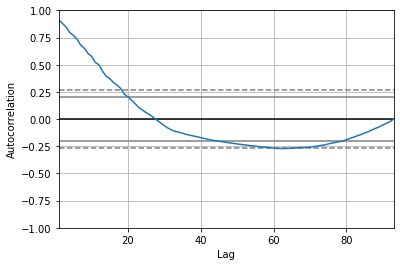

In [11]:
from pandas.plotting import autocorrelation_plot # This is what we use for the autocorrelation plot
autocorrelation_plot(y)
plt.show()

There is a postive correlation for the first 25 or so lags, and it is significant at least for the first 15. 15 might be a good "AR" value to start with for this model.

In [12]:
from statsmodels.tsa.arima.model import ARIMA # Import the ARIMA model
model = ARIMA(y, order=(15,1,0)) # d, or the differencing order, is 1, to make the data stationary
model_fit = model.fit() # fit the model
print(model_fit.summary()) # Print the results (although these are quite hard to understand!)

                               SARIMAX Results                                
Dep. Variable:        Daily Confirmed   No. Observations:                   93
Model:                ARIMA(15, 1, 0)   Log Likelihood                -545.488
Date:                Mon, 28 Sep 2020   AIC                           1122.975
Time:                        19:44:16   BIC                           1163.324
Sample:                    01-30-2020   HQIC                          1139.260
                         - 05-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7062      0.111     -6.356      0.000      -0.924      -0.488
ar.L2         -0.2469      0.104     -2.374      0.018      -0.451      -0.043
ar.L3         -0.2100      0.121     -1.741      0.0

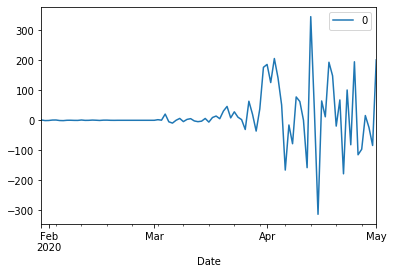

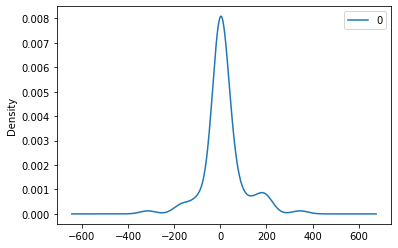

                0
count   93.000000
mean    13.940656
std     84.511567
min   -313.739453
25%     -0.772805
50%      0.207453
75%     20.075993
max    345.854557


In [13]:
residuals = pd.DataFrame(model_fit.resid) # It's easier to find and plot the residuals (i.e. the error)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

What does the above show us? Well, we can see that our errors start very small, and as time goes on they get pretty big. Overall, the mean error is only 13.9, which given that our number of cases gets up to over 2,000, isn't that bad! What's more, our maximum arror is 346, which only represents an error of around 14% on the highest figure in the dataset. We can now use the ARIMA model to predict values and see how effective it is

predicted=148.074128, expected=309.000000
predicted=277.270039, expected=424.000000
predicted=445.231194, expected=486.000000
predicted=623.196982, expected=560.000000
predicted=663.038916, expected=579.000000
predicted=652.343263, expected=609.000000
predicted=666.296550, expected=484.000000
predicted=375.800337, expected=573.000000
predicted=581.526397, expected=565.000000
predicted=605.943532, expected=813.000000
predicted=832.349534, expected=871.000000
predicted=1054.211912, expected=854.000000
predicted=815.101649, expected=758.000000
predicted=695.261381, expected=1243.000000
predicted=1316.634351, expected=1031.000000
predicted=995.283357, expected=886.000000
predicted=987.338481, expected=1061.000000
predicted=1405.462233, expected=922.000000
predicted=790.212903, expected=1371.000000
predicted=1311.866050, expected=1580.000000
predicted=1180.934048, expected=1239.000000
predicted=1365.718626, expected=1537.000000
predicted=1864.633751, expected=1292.000000
predicted=1482.4097

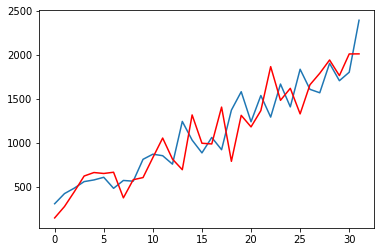

In [14]:
from sklearn.metrics import mean_squared_error
X = y.values # This will be the x axis rather than the dates
size = int(len(X) * 0.66) # This is to give us a training set that is 2/3 of our data
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(15,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() # This is how we forecast out values from the training set
    yhat = output[0] # We're jus takign the first forecast value for plotting later
    predictions.append(yhat) # Collect the predictions in the list we created earlier
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Our graph shows us that our model it not too bad - it follows the trend and the root mean squared error is 262 (that's the square root of MSE above, which is 68895). While not perfect, we can see from the predictions vs expected result that we aren't miles off with each prediction. This, remember, is the later part of the dataset (i.e. the last 30 results), because we took 1/3 of our data as the test set. From our earlier graph, we knew that this was where things go tricky for the model, whereas earlier on the model was more accurate.

There is, however, a way we can make our model better. When we performed the decomposition earlier, there was seasonality to the data, i.e. it repeated itself every x time steps. x, in this case, is 7, meaning there is weekly seasonality. We can use seasonal ARIMA (SARIMA) to model this and hopefully get a better result. This requires a second set of (p,d,q) values to cover seasonality, and a value "s" which is for seasonality. s will be 7 in this case, as the data repeats itself every seven steps. We'll also take this opportunity to fine-tune our other pdq values by using grid search - this means cycling through all of the combinations for p,d,q to find the best ones and then fitting the model based on that

In [15]:
import itertools
# We'll use grid search to find the best paramaters for our SARIMA model
p = d = q = range(0,3) # p,d,q is either 0,1,2
pdq = list(itertools.product(p,d,q)) # this gives us all of the possible combinations of p, d, and q 
p2= d2 = q2 = range(0, 2) # second set of p's, d's, and q's (i.e. seasonal paramaters)
pdq2 = list(itertools.product(p2,d2,q2)) # this is for our seasonal parameters
s = 7 # this is because we saw weekly seasonality when we performed decomposition earlier
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = [] # This is a list for our error metrics
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)

predicted=155.102307, expected=309.000000
predicted=355.106978, expected=424.000000
predicted=500.059466, expected=486.000000
predicted=597.684883, expected=560.000000
predicted=609.007995, expected=579.000000
predicted=607.288463, expected=609.000000
predicted=686.379992, expected=484.000000
predicted=419.649894, expected=573.000000
predicted=637.282364, expected=565.000000
predicted=588.076329, expected=813.000000
predicted=878.648879, expected=871.000000
predicted=903.496925, expected=854.000000
predicted=883.689489, expected=758.000000
predicted=731.285274, expected=1243.000000
predicted=1145.547951, expected=1031.000000
predicted=1144.394864, expected=886.000000
predicted=1133.965047, expected=1061.000000
predicted=1153.312578, expected=922.000000
predicted=1043.502783, expected=1371.000000
predicted=1226.378419, expected=1580.000000
predicted=1416.121651, expected=1239.000000
predicted=1413.648682, expected=1537.000000
predicted=1493.342916, expected=1292.000000
predicted=1532.65

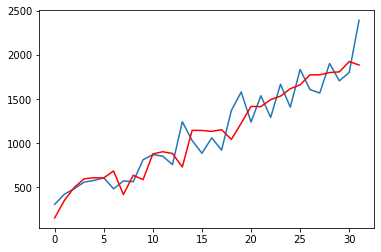

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX # Import the seasonal ARIMA model
# We'll do the same thing as we did last time and print out our predicted values and the real values to see how good the model is
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=combs[best_aic][0], seasonal_order=combs[best_aic][1], enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast() # This is how we forecast out values from the training set
    yhat = output[0] # We're jus takign the first forecast value for plotting later
    predictions.append(yhat) # Collect the predictions in the list we created earlier
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

We can see straight away that our Test MSE is much lower, and RMSE is 204 (that's quite a significant improvement on 262). Adding in seasonality has been improved the model, as it has taken into account the seasonality of the data and given us better predictions.